In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Fetch The Image

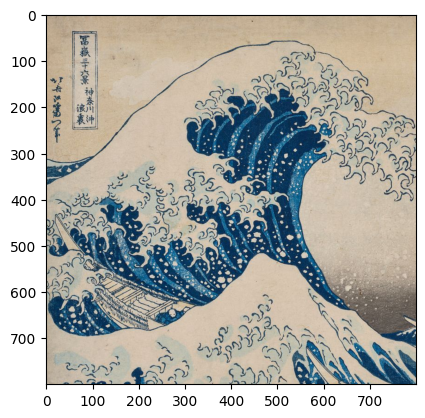

In [29]:
import requests

img_url = "https://images.wsj.net/im-747739?width=700&size=1.4831981460023176&pixel_ratio=2"

# Downlaod the image from URL
img_data = requests.get(img_url).content

# Save the image
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

# Read the image
img = plt.imread('img.jpg')

# Crop the first 800 x 800 of the image
img = np.asarray(img)[:800, :800, :]

# Show the image
plt.imshow(img)
plt.show()

# Save cropped image
plt.imsave('img.jpg', img)

# What does a 2D Gaussian Look Like

This is the classic image of a 2D gaussian that we always see. It is a 2D gaussian with a mean of 0 and a variance of 1. The gaussian is centered at the origin and the variance is 1 in both the x and y directions.

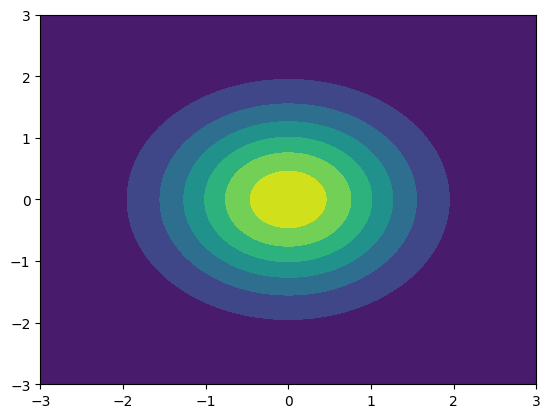

/var/folders/6g/thg9y0497wzgtsbbk8t3bjxm0000gn/T/ipykernel_64060/3651175870.py:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


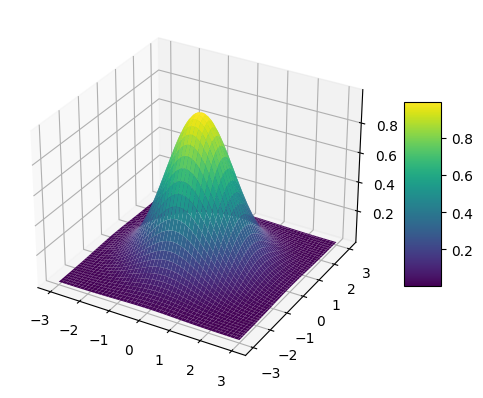

In [15]:
# Mean vector and covariance matrix
mu = np.array([0., 0.])
sigma = np.array([[1., 0.], [0., 1.]])

# Generate a grid of points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)

XY = np.stack((X, Y), axis=2)

# Compute the probability density function - this is a vectorized version
# Also the mahanalobis distance is used here
# XY - mu is a vector of shape (100, 100, 2)
# np.linalg.inv(sigma) is the inverse of the covariance matrix
# (XY -  mu).T @ inv(sigma) @ (XY - mu) is the mahanalobis distance
# We don't take transpose here since we are using einsum
Z = np.exp(-0.5 * np.einsum('...j,ij,...i', XY - mu, np.linalg.inv(sigma), XY - mu))

# Plot the gaussian distribution
plt.contourf(X, Y, Z)
plt.show()

# The same plot in 3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# What does noise in diffusion look like then?

If we try to imagine the above gaussian on an image, we'd probably think of something like this:

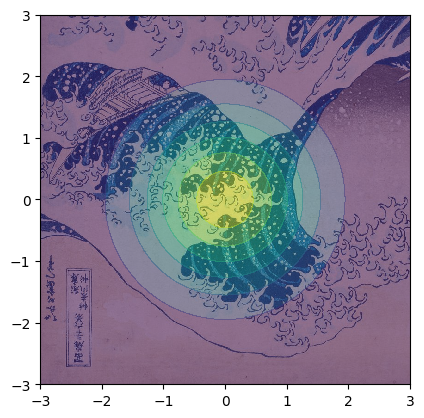

In [31]:
# Plot the image and overlay the gaussian distribution

extent = x.min(), x.max(), y.min(), y.max()

# Plot the image
plt.imshow(img, interpolation='nearest', origin='lower',
           extent=extent)

# Plot the gaussian distribution
plt.contourf(X, Y, Z, alpha=0.5)
plt.show()

I haven't resized the image well, but this is probably the first idea that we think of when we hear 2D gaussian on an image - a gaussian blob that is centered at a point. However, in diffusion, it's something different.

In diffusion, we usually do the following in the forward process:

$$x_t = x * a + \epsilon * b,$$

where $x_t$ is the image $x$ at time $t$ (after $t$ steps of forward diffusion), $\epsilon$ is the noise, and $a$ and $b$ are constants not relevant for this discussion.

If we look at code for this, it would be something like this:

In [41]:
noise = np.random.normal(size=img.shape)

print(noise.shape)

(800, 800, 3)


As we can see, the shape of the noise is the same as the shape of the image but what does this mean in terms of the gaussian? If we visualise the noise, we get something like this:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


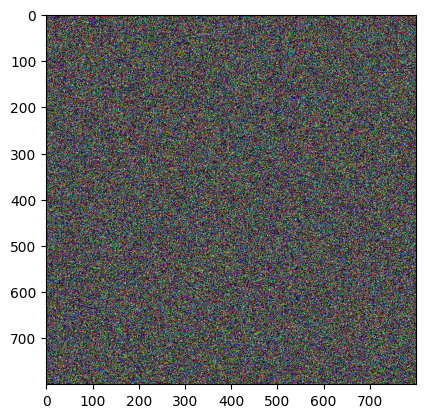

Min -4.767353729786482
Max 5.391762122203972


In [42]:
plt.imshow(noise)
plt.show()

print("Min", noise.min())
print("Max", noise.max())

This does NOT look like a gaussian immediately - where's the bell curve? Where's the peak? Where's the mean? Where's the variance?

Underneath the hood, what `np.random.normal()` actually does is draw from a 0 centered gaussian at every index individually (independent of other pixels). As a result, we may be looking at a 2D image, but the noise is drawn as follows:

For a pixel coordinate (x, y), for each channel (r, g, b), we draw from a 0 centered gaussian. This means that the noise is drawn independently for each pixel and each channel. This is why we see the noise as a 2D image, but it is not a 2D gaussian. Hence, there is no discnerable trend in the image's noise. We can visualise this in another way too.

Min 0.0
Max 1.0


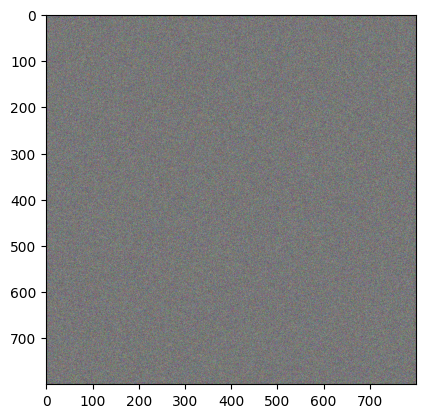

In [43]:
# Normalise the noise
noise = (noise - noise.min()) / (noise.max() - noise.min())

print("Min", noise.min())
print("Max", noise.max())

# Plot the noise
plt.imshow(noise)
plt.show()

Here, we have normalised the noise and plotted it - to get a gray image. Some facts:

1. The noise that was previously centered at 0 is now centered at 0.5 (after normalising).
2. The range of the noise is now between 0 and 1 (after normalising).
3. (0.5, 0.5, 0.5) is hence the mean pixel value of the noise.
4. (0.5, 0.5, 0.5) is simply a gray image! (half black, half white if that's an easy way to think)

If we plot a single channel individually, we will find ourselve's validated too:

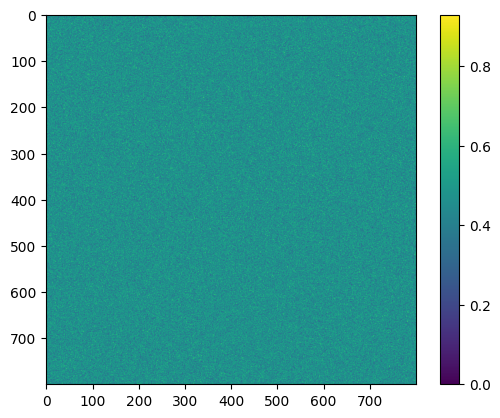

In [45]:
plt.imshow(noise[..., 0])
plt.colorbar()
plt.show()

# Conclusion

To put everything together in the context of diffusion models - we want to slowly add noise to the image. This means - moving the pixel colours here and there slowly. At the first few timesteps, the noise should be minimal - so each pixel gets moved little (the gaussian noise is scaled by a factor). As we move forward in time, the noise should increase - so each pixel gets moved more (the gaussian noise is scaled by a factor). This is why we see the image slowly get more and more noisy as we move forward in time.

Regarding the values of the noise itself, the noise is typically centered at 0 in diffusion models - this is because we've rescaled our input to be (-1, 1). 